In [1]:
import os

os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"

In [2]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import (
    fast_filter,
    get_rot_kernel,
    fit_uncertainties,
)
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from numba import jit
from astropy.io import fits
from scipy import interpolate
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import time

R_s = 1.756 * R_Sun  # Stellar radius (m)
T_s = 6250  # Stellar effective temperature (K)
Met_s = 0.23  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.13  # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid="phoenix")

F_s = star["F_star"]
wl_s = star["wl_star"]
R_s = star["R_s"]


# ***** Define planet properties *****#

planet_name = "WASP-76b"  # Planet name used for plots, output files etc.

R_p = 1.830 * R_J  # Planetary radius (m)
M_p = 0.92 * M_J  # Mass of planet (kg)
g_p = 10 ** (2.83 - 2)  # Gravitational field of planet (m/s^2)
T_eq = 2182  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# ***** Define model *****#

model_name = "Make Injection Data"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = ["Na"]

# Create the model object
model = define_model(model_name, bulk_species, param_species, PT_profile="isotherm")

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))


# ***** Wavelength grid *****#

wl_min = 0.37  # Minimum wavelength (um)
wl_max = 1.05  # Maximum wavelength (um)
R = 200000  # Spectral resolution of grid

# wl = wl_grid_line_by_line(wl_min, wl_max)
wl = wl_grid_constant_R(wl_min, wl_max, R)

# ***** Read opacity data *****#

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 1500  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 4500  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.5  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

# Specify the pressure grid of the atmosphere
P_min = 1e-12  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-2  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

log_Na, T = (-7, 3000)

PT_params = np.array([T])
log_X_params = np.array([[log_Na]])

atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, log_X_params)

# Generate planet surface flux
spectrum = compute_spectrum(
    planet, star, model, atmosphere, opac, wl, spectrum_type="transmission"
)

Free parameters: ['R_p_ref' 'T' 'log_Na']
Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
Na done
Opacity pre-interpolation complete.


In [3]:
model_name = "Continuum"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = []

# Create the model object
model = define_model(model_name, bulk_species, param_species, PT_profile="isotherm")

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))

T = 3000

# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([T])

atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, log_X_params)

# Generate planet surface flux
continuum = compute_spectrum(
    planet, star, model, atmosphere, opac, wl, spectrum_type="transmission"
)

Free parameters: ['R_p_ref' 'T']


In [4]:
from POSEIDON.utility import read_high_res_data
from POSEIDON.high_res import fit_uncertainties
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = (
    "/home/ruizhew/POSEIDON/high_res_experiments/data/"  # without blaze correction
)
wl_grid, data_raw = pickle.load(open(data_dir + "data_raw.pic", "rb"))
data = read_high_res_data(
    "/home/ruizhew/POSEIDON/POSEIDON/reference_data/observations/WASP-76b/",
    method="sysrem",
    spectrum_type="transmission",
)
data_raw[data_raw < 0] = 0
data["data_raw"] = data_raw
Ndet, Nphi, Npix = data_raw.shape

Fast filter has not been run yet. Please save the basis array (Bs) for each order and the residuals before running retrievals.


In [5]:
from scipy.ndimage import gaussian_filter1d, median_filter

W_conv = 5
a = 4.5
b = 1
model = (spectrum - continuum) * a + continuum
# spectrum_broadened = gaussian_filter1d(model, W_conv)
spectrum_broadened = model

In [6]:
V_sys = -15
K_p = -210
dPhi = 0
Phi = data["phi"]
RV_p = V_sys + K_p * np.sin(
    2 * np.pi * (Phi + dPhi)
)  # V_sys is an additive term around zero
dl_p = RV_p * 1e3 / constants.c  # delta lambda, for shifting
cs_p = interpolate.splrep(wl, spectrum_broadened, s=0.0)
tmodel1 = data["transit_weight"]

In [7]:
def test_loop_np():
    models_shifted = np.zeros(
        data_raw.shape
    )  # "shifted" model spectra array at each phase
    for i in range(Ndet):
        for j in range(Nphi):
            wl_shifted_p = wl_grid[i] * (1.0 - dl_p[j])
            Fp = np.interp(wl_shifted_p, wl, spectrum_broadened)
            models_shifted[i][j] = ((1 - tmodel1[j])) / np.max(1 - tmodel1) * (-Fp) + 1
    return models_shifted

In [8]:
models_shifted = test_loop_np()

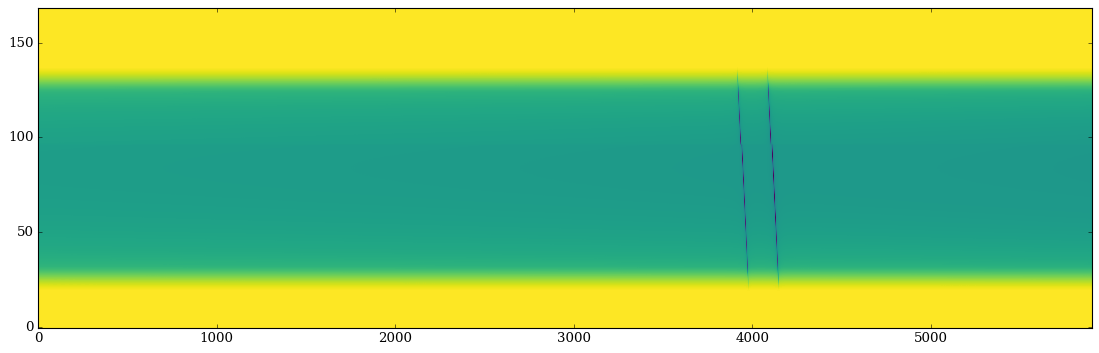

In [9]:
output_path = "./CC_output/WASP-76b-injection-Na-7/"
os.makedirs(output_path, exist_ok=True)

plt.figure(figsize=(17, 5))
plt.imshow(models_shifted[10], aspect="auto", origin="lower", cmap="viridis")
plt.savefig(output_path + "shifted_model.pdf", fmt="pdf")

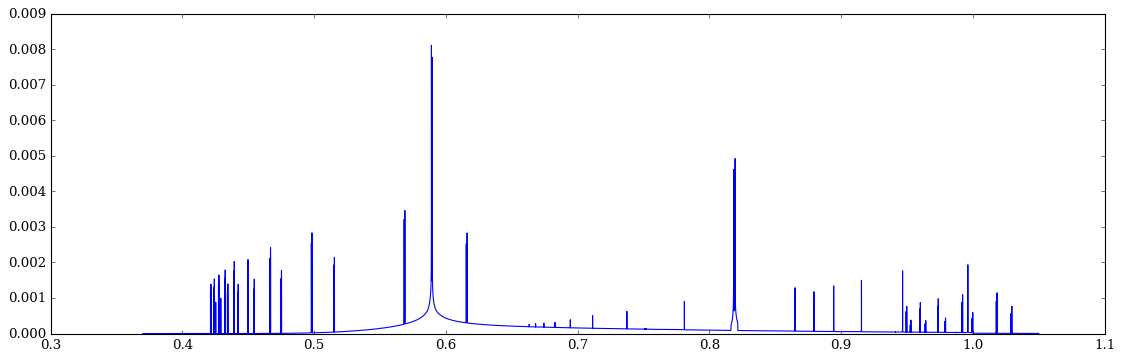

In [10]:
plt.figure(figsize=(17, 5))
plt.plot(wl, spectrum - continuum)
plt.ticklabel_format(useOffset=False)

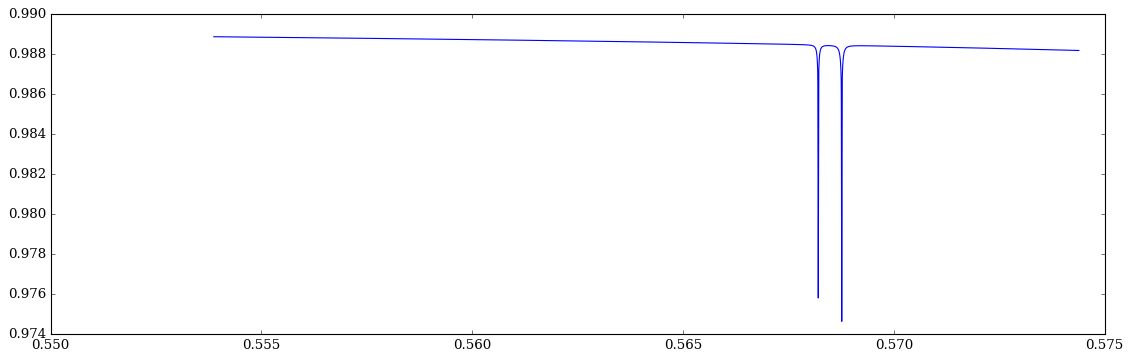

In [11]:
plt.figure(figsize=(17, 5))
plt.plot(wl_grid[10], models_shifted[10][100])
plt.ticklabel_format(useOffset=False)

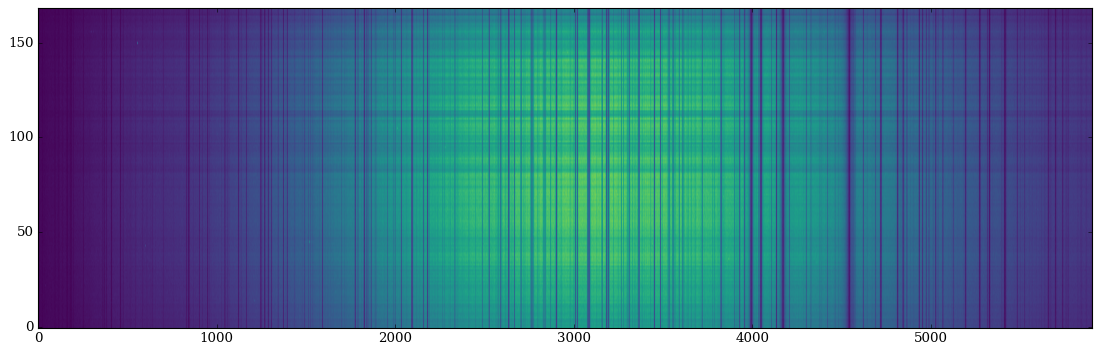

In [12]:
plt.figure(figsize=(17, 5))
plt.imshow(data_raw[6], aspect="auto", origin="lower", cmap="viridis")
plt.savefig(output_path + "aligned_data.pdf", fmt="pdf")

In [13]:
data_injected = data_raw
# data = models_shifted * data_raw

In [14]:
C_norm = np.zeros(data_injected.shape)
for k in range(Ndet):
    order = data_injected[k]

    middle = np.median(order, axis=0)
    middle[middle == 0] = np.mean(middle)  # dummy value so no dividing zero
    order_norm = order / middle

    C_norm[k] = order_norm

In [15]:
from scipy.ndimage import gaussian_filter1d, median_filter

for det in range(Ndet):
    for phi in range(Nphi):
        C_norm[det][phi] = median_filter(C_norm[det][phi], size=501)

for det in range(Ndet):
    for phi in range(Nphi):
        C_norm[det][phi] = gaussian_filter1d(C_norm[det][phi], sigma=100)

In [16]:
data = data_injected / C_norm

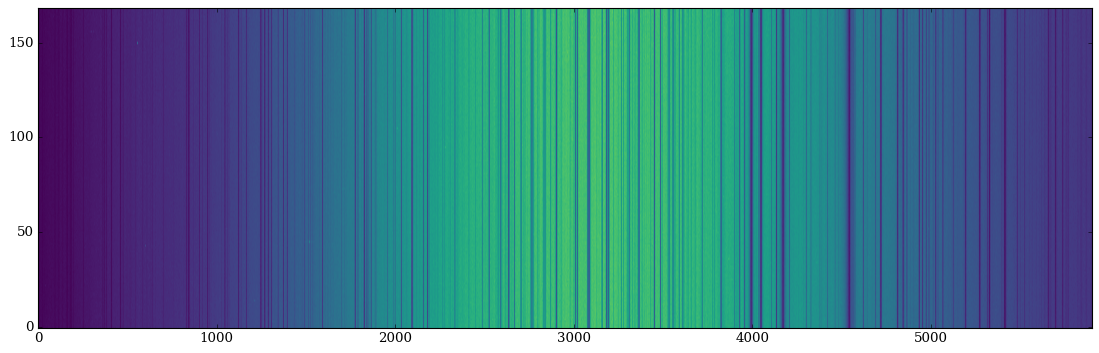

In [17]:
plt.figure(figsize=(17, 5))
plt.imshow(data[6], aspect="auto", origin="lower", cmap="viridis")
plt.savefig(output_path + "blaze_corrected.pdf", fmt="pdf")

In [18]:
data = data * models_shifted

In [19]:
uncertainties = fit_uncertainties(data, NPC=5)

In [20]:
mask = data == 0
uncertainties[mask] = 1e7

In [21]:
output_data_dir = "/home/ruizhew/POSEIDON/high_res_experiments/data/WASP-76b-injection-Na-7/"  # directory of the injected data (different from clean data)
pickle.dump(
    uncertainties,
    open(output_data_dir + "uncertainties.pic", "wb"),
)
pickle.dump(
    [wl_grid, data],
    open(output_data_dir + "data_raw.pic", "wb"),
)

In [22]:
import pickle

uncertainties = pickle.load(open(output_data_dir + "/uncertainties.pic", "rb"))
wl_grid, data = pickle.load(open(output_data_dir + "/data_raw.pic", "rb"))

In [23]:
from POSEIDON.high_res import fast_filter

for i in range(len(data)):
    order = data[i]

    median = np.median(order, axis=0)
    median[median == 0] = np.mean(median)
    order_norm = order / median

    uncertainty = uncertainties[i]

    uncertainty_norm = uncertainty / median

    uncertainties[i] = uncertainty_norm
    data[i] = order_norm

residuals, Us = fast_filter(data, uncertainties, N_iter=15)

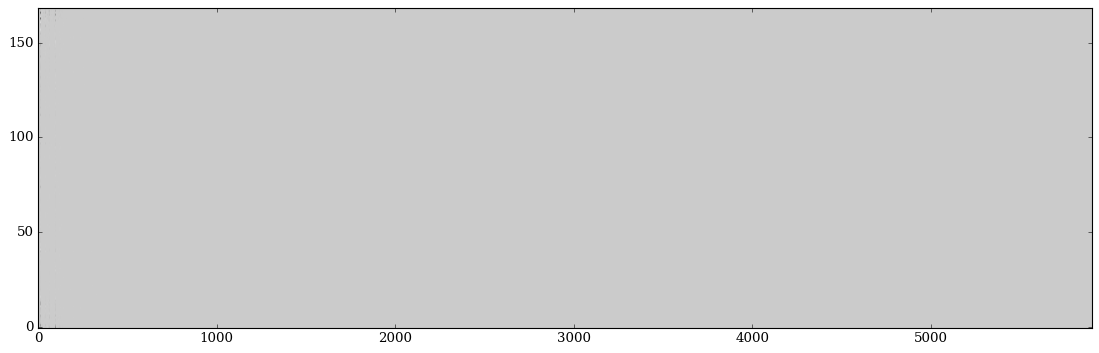

In [24]:
plt.figure(figsize=(17, 5))
plt.imshow(residuals[0], aspect="auto", origin="lower", cmap="gray")
plt.savefig(output_path + "filtered.pdf", fmt="pdf")

In [25]:
Bs = np.zeros((Ndet, Nphi, Nphi))

for j in range(Ndet):
    U = Us[j]
    L = np.diag(1 / np.mean(uncertainties[j], axis=-1))
    B = U @ np.linalg.pinv(L @ U) @ L
    Bs[j] = B

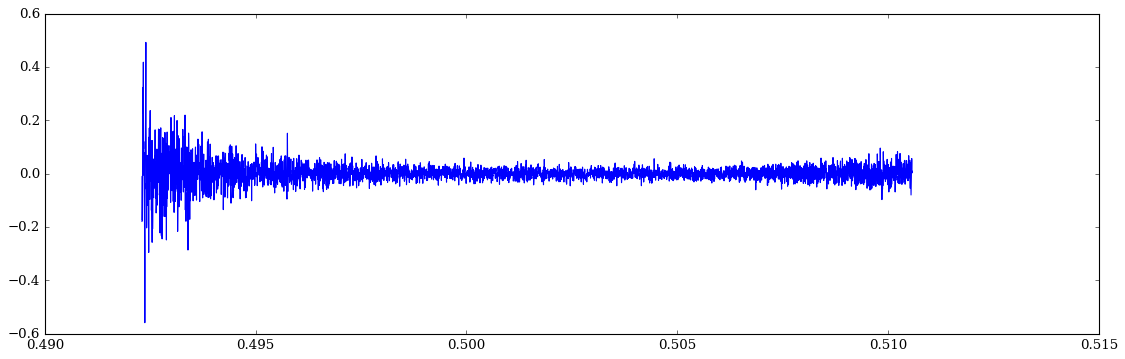

In [26]:
plt.figure(figsize=(17, 5))
plt.plot(wl_grid[5], residuals[5][50])
plt.ticklabel_format(useOffset=False)

In [27]:
j = 5
models_shifted = test_loop_np()
models_shifted = models_shifted[5]

In [28]:
models_shifted = (models_shifted.T / np.median(models_shifted, axis=1)).T
B = Bs[j]
model_filtered = models_shifted - B @ models_shifted

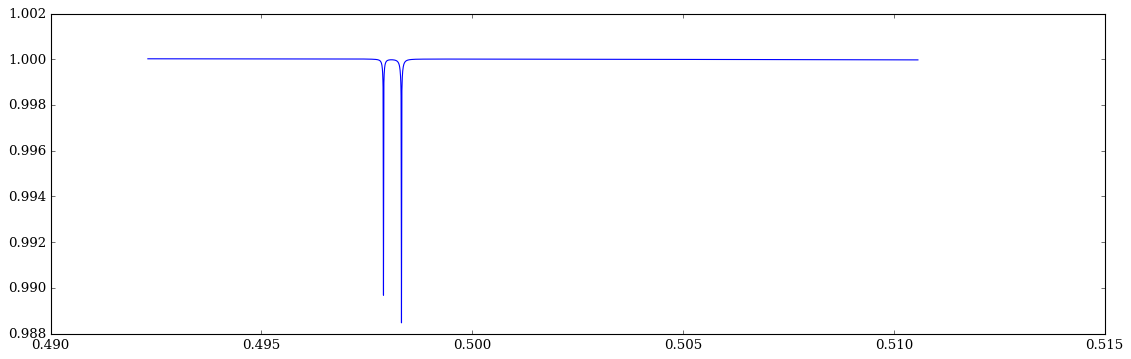

In [29]:
plt.figure(figsize=(17, 5))
plt.plot(wl_grid[5], models_shifted[50])
plt.ticklabel_format(useOffset=False)

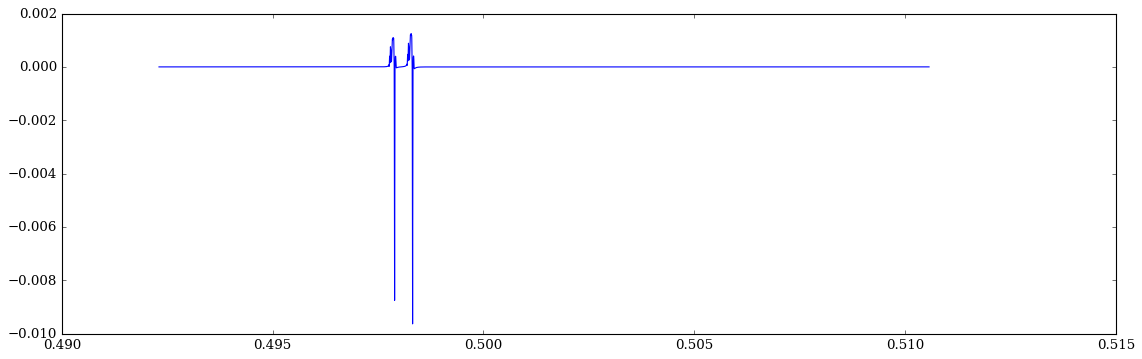

In [30]:
plt.figure(figsize=(17, 5))
plt.plot(wl_grid[5], model_filtered[50])
plt.ticklabel_format(useOffset=False)

In [31]:
pickle.dump([Bs, residuals], open(output_data_dir + "fast_filter.pic", "wb"))